Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 4s - 117ms/step - loss: 0.2124 - val_loss: 0.1151
Epoch 2/50
38/38 - 1s - 13ms/step - loss: 0.0225 - val_loss: 0.1281
Epoch 3/50
38/38 - 1s - 16ms/step - loss: 0.0142 - val_loss: 0.1278
Epoch 4/50
38/38 - 1s - 16ms/step - loss: 0.0134 - val_loss: 0.1574
Epoch 5/50
38/38 - 1s - 17ms/step - loss: 0.0119 - val_loss: 0.1461
Epoch 6/50
38/38 - 1s - 16ms/step - loss: 0.0130 - val_loss: 0.1028
Epoch 7/50
38/38 - 1s - 14ms/step - loss: 0.0111 - val_loss: 0.1503
Epoch 8/50
38/38 - 1s - 13ms/step - loss: 0.0101 - val_loss: 0.1036
Epoch 9/50
38/38 - 1s - 18ms/step - loss: 0.0097 - val_loss: 0.1252
Epoch 10/50
38/38 - 1s - 21ms/step - loss: 0.0096 - val_loss: 0.1376
Epoch 11/50
38/38 - 1s - 20ms/step - loss: 0.0088 - val_loss: 0.1474
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Squared Error: 3507310.16
R-squared: 0.4968


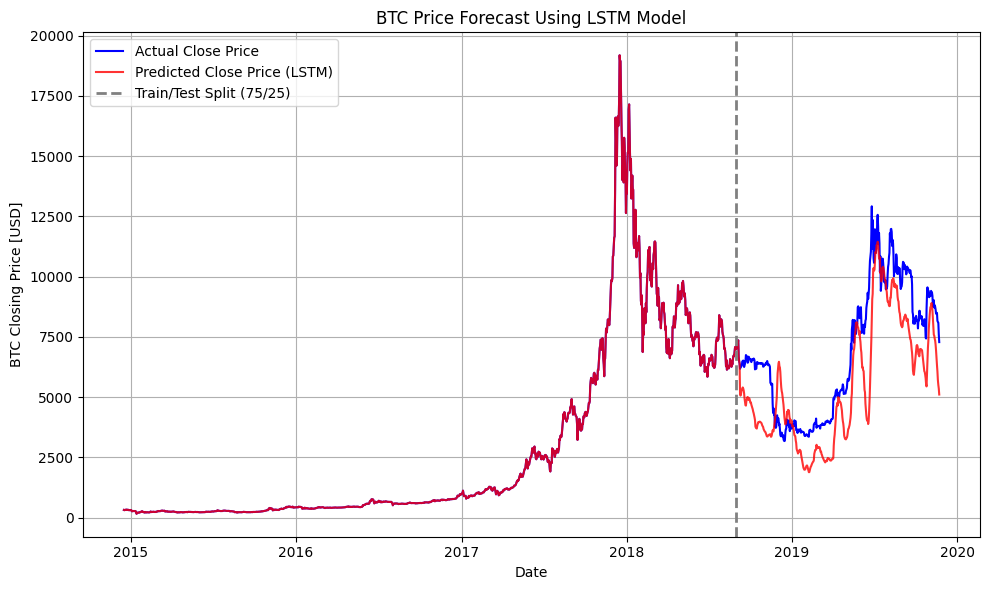

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Preparing Data
sentiments = pd.read_csv('DailySentimentSummary.csv')
price = pd.read_csv('BTC-Daily.csv')

#Standardizing Column Names and Dates
for dataset in (sentiments, price):
    dataset.columns = dataset.columns.str.strip().str.lower().str.replace(' ', '_')
    dataset['date'] = pd.to_datetime(dataset['date']).dt.date

price = price[['date', 'high', 'low', 'close', 'volume_btc']]
combined_data = pd.merge(price, sentiments, on='date', how='inner').sort_values('date').reset_index(drop=True)

#Features

#Sentiment Ratios
combined_data['positive_sent'] = combined_data['positive_tweets'] / combined_data['total_tweets']
combined_data['negative_sent'] = combined_data['negative_tweets'] / combined_data['total_tweets']
combined_data['neutral_sent']  = combined_data['neutral_tweets']  / combined_data['total_tweets']

#Lag Features
combined_data['sentiment_lag1'] = combined_data['avg_compound_score'].shift(1)
combined_data['price_lag1'] = combined_data['close'].shift(1)

#3 Day Averages
combined_data['sentiment_3d_avg'] = combined_data['avg_compound_score'].rolling(3).mean()
combined_data['price_3d_avg'] = combined_data['close'].rolling(3).mean()

#Momentum
combined_data['price_pct_change'] = combined_data['close'].pct_change()

#7 Day Volatility
combined_data['volatility_7d'] = combined_data['close'].rolling(window=7).std()

#Technical Indicators
#Commonly used for financial data

#Moving Average Convergence Divergence
ema12 = combined_data['close'].ewm(span=12, adjust=False).mean()
ema26 = combined_data['close'].ewm(span=26, adjust=False).mean()
combined_data['macd'] = ema12 - ema26

#Relative Strength Index (14 day)
delta = combined_data['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
combined_data['rsi14'] = 100 - (100 / (1 + rs))

#Bollinger Bandwidth
mb = combined_data['close'].rolling(20).mean()
sd20 = combined_data['close'].rolling(20).std()
combined_data['boll_bandwidth'] = (mb + 2 * sd20 - (mb - 2 * sd20)) / mb

#Average True Range (14 day)
tr1 = combined_data['high'] - combined_data['low']
tr2 = (combined_data['high'] - combined_data['close'].shift(1)).abs()
tr3 = (combined_data['low'] - combined_data['close'].shift(1)).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
combined_data['atr14'] = tr.rolling(window=14).mean()

#On-Balance Volume
direction = np.sign(combined_data['close'].diff()).fillna(0)
combined_data['obv'] = (direction * combined_data['volume_btc']).cumsum()

#Set Tomorrow's Closing Price as Target Variable
combined_data['target'] = combined_data['close'].shift(-1)
combined_data.dropna(inplace=True)
combined_data.reset_index(drop=True, inplace=True)

#Splitting Data into Train/Test at 75% Chronologically
split_data = int(len(combined_data)*0.75)
train_data = combined_data.iloc[:split_data]
test_data = combined_data.iloc[split_data:]

#Set Features
features = ['price_lag1', 'avg_compound_score', 'positive_sent', 'negative_sent', 'neutral_sent', 'sentiment_lag1', 'sentiment_3d_avg', 'price_3d_avg', 'price_pct_change', 'volatility_7d', 'macd', 'rsi14', 'boll_bandwidth', 'atr14', 'obv']

#LSTM Sequence
def create_sequences(data, features, target, window=10):
    X, y, lag_close = [], [], []
    for i in range(window, len(data)):
        X.append(data[features].iloc[i-window:i].values)
        y.append(data[target].iloc[i])
        lag_close.append(data['price_lag1'].iloc[i])
    return np.array(X), np.array(y), np.array(lag_close)

window = 10
X_train, y_train, lag_train = create_sequences(train_data, features, 'target', window)
X_test,  y_test,  lag_test  = create_sequences(test_data,  features, 'target', window)

#Scale Features
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))

num_samples, nt, num_features = X_train.shape
scaler_X = StandardScaler().fit(X_train.reshape(num_samples*nt, num_features))
X_train = scaler_X.transform(X_train.reshape(num_samples*nt, num_features)).reshape(num_samples, nt, num_features)

num_samples2 = X_test.shape[0]
X_test = scaler_X.transform(X_test.reshape(num_samples2*nt, num_features)).reshape(num_samples2, nt, num_features)

#Create Model
model = Sequential([LSTM(64, return_sequences=True, input_shape=(window, num_features)), Dropout(0.2), LSTM(32), Dense(1)])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stop], verbose=2)

#Making Predictions
#Predicts tomorrow's closing price using Twitter Sentiment and previous prediction
y_pred_scaled = model.predict(X_test).flatten()
pred_prices = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

#Analysis Values and Plot
mse = mean_squared_error(y_test, pred_prices)
r2 = r2_score(y_test, pred_prices)
print(f'Mean Squared Error: {mse:.2f}')
print(f"R-squared: {r2:.4f}")

pre_split_actual = list(combined_data.loc[:split_data + window - 1, 'close'])  # up to start of test sequence
pred_full = pre_split_actual + list(pred_prices)
full_dates = list(combined_data.loc[:split_data + window - 1, 'date']) + list(test_data['date'].values[window:])

plt.figure(figsize=(10, 6))
plt.plot(combined_data['date'], combined_data['close'], label='Actual Close Price', color='blue')
plt.plot(full_dates, pred_full, label='Predicted Close Price (LSTM)', color='red', alpha=0.8)
plt.axvline(x=combined_data.loc[split_data, 'date'], color='gray', linestyle='--', linewidth=2, label='Train/Test Split (75/25)')
plt.xlabel('Date')
plt.ylabel('BTC Closing Price [USD]')
plt.title('BTC Price Forecast Using LSTM Model')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()